# Setup

**Imports**

In [346]:
import datetime as dt
from math import log
import IPython
import geopandas
import contextily as cx
from math import asin, cos, radians, sin, sqrt
import networkx as nx
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.fft import fft
from scipy.signal import stft
from scipy.signal import butter, filtfilt
from scipy.signal import hilbert
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
rng = np.random.default_rng()

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

9


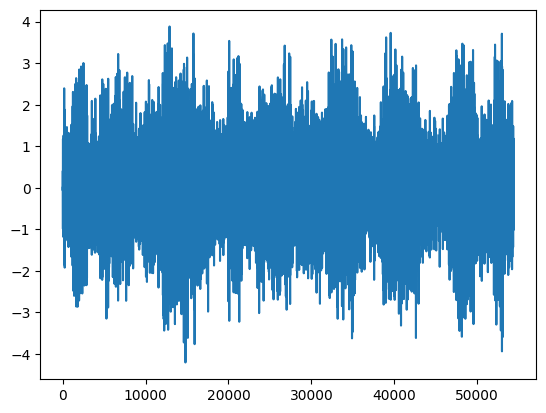

In [ ]:
n = 48
signal = X_train[n]
print(len(y_train[n]))
def extract_segments(signal):
    # 1 - We filter the signal with low and high frequencies
    lowcut = 500
    highcut = 1700
    b, a = butter(N=4, Wn=[lowcut, highcut], btype='band', fs=FS)
    signal_filtered = filtfilt(b, a, signal)

    # 2 - We perform a change point detection algorithm with it
    pen = 0.025*2 * np.log(len(signal_filtered)) * np.std(signal_filtered)**2
    window_length = 256
    overlap = window_length // 2
    f, t, Zxx = stft(signal_filtered, fs=FS, nperseg=window_length, noverlap=overlap)
    energy_feature = np.sum(np.abs(Zxx)**2, axis=0)
    predicted_bkps = rpt.Pelt(model="l2").fit_predict(energy_feature, pen=pen)
    frame_step = window_length - overlap
    # Map feature index to signal sample
    signal_bkps = [min(int(idx * frame_step), len(signal_filtered)) for idx in predicted_bkps[:-1]] 
    
    # 3 - We split into segments
    segments = []
    segment_averages = []

    squared_signal_filtered = np.abs(signal_filtered)**2
    
    # Make sure breakpoints start at 0 and end at signal length
    if signal_bkps[0] != 0:
        signal_bkps = [0] + signal_bkps 
    if signal_bkps[-1] != len(signal):
        signal_bkps = signal_bkps + [len(signal)]

    
    for i in range(len(signal_bkps)-1):
        start = signal_bkps[i]
        end = signal_bkps[i+1]
        seg = squared_signal_filtered[start:end]
        segments.append(seg)
        segment_averages.append(np.mean(seg))

    # 4 - We do Kmeans classifier to detect sound and noise segments
    X = np.array(segment_averages).reshape(-1,1)
    kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
    labels = kmeans.labels_
    assert len(labels) == len(signal_bkps) - 1

    # 5 - We extract sound segments
    sound_segments = []

    # there are len(signal_bkps)-1 segments
    for i in range(len(labels)):
        start = signal_bkps[i]
        end = signal_bkps[i+1]

        if labels[i] == 0:  # keep this segment
            sound_segments.append((start, end))

    return sound_segments


#analytic_signal = hilbert(signal_filtered)
#envelope = np.abs(analytic_signal)
#envelope_smooth = np.convolve(envelope, np.ones(5)/5, mode='same')
#max_env = np.max(envelope_smooth)
#silence_threshold = 0.1 * max_env
plt.plot(signal_filtered)
#IPython.display.Audio(signal, rate=FS)
IPython.display.Audio(signal_filtered, rate=FS)

In [336]:
n = 15 
segments = extract_segments(X_train[n])
print(segments)

[(2560, 5760), (8320, 10240), (10240, 12800), (16640, 17920), (21120, 23040), (24960, 27520), (30080, 33920), (37120, 39680)]


In [337]:
import numpy as np
from scipy.signal import find_peaks

def estimate_frequencies(segment, FS, n_peaks=2):
    """
    Estimate the two dominant frequencies in a segment.
    
    Parameters:
        segment : 1D array
            The signal segment (variable length)
        FS : int or float
            Sampling frequency
        n_peaks : int
            Number of dominant peaks to return (default 2)
    
    Returns:
        dominant_freqs : list of floats
            Sorted list of the estimated frequencies (low freq first)
    """
    N = len(segment)
    # Compute FFT
    fft_vals = np.fft.rfft(segment)
    fft_magnitude = np.abs(fft_vals)
    
    # Frequency axis
    freqs = np.fft.rfftfreq(N, 1/FS)
    
    # Ignore DC component
    fft_magnitude[0] = 0
    
    # Find peaks
    peak_indices, _ = find_peaks(fft_magnitude, height=np.max(fft_magnitude)*0.1)
    
    if len(peak_indices) < n_peaks:
        # If not enough peaks found, take top n_peaks largest values
        peak_indices = np.argsort(fft_magnitude)[-n_peaks:]
    
    # Take the n_peaks highest peaks
    peak_magnitudes = fft_magnitude[peak_indices]
    top_indices = peak_indices[np.argsort(peak_magnitudes)[-n_peaks:]]
    
    # Map to frequencies and sort low → high
    dominant_freqs = sorted(freqs[top_indices])
    
    return dominant_freqs


In [ ]:
F_train = []      # will contain pairs (f1, f2)
Y_flat = []       # will contain the corresponding labels

for signal, labels in zip(X_train, y_train):
    segments = extract_segments(signal)
    
    # The number of segments ≈ len(labels), but may be slightly off
    min_len = min(len(segments), len(labels))

    for i in range(min_len):
        start, end = segments[i]
        segment_data = signal[start:end]

        f1, f2 = estimate_frequencies(segment_data, FS)
        
        F_train.append([f1, f2])
        Y_flat.append(labels[i])  # Corresponding symbol


698
698


Unique labels: ['#', '*', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D']


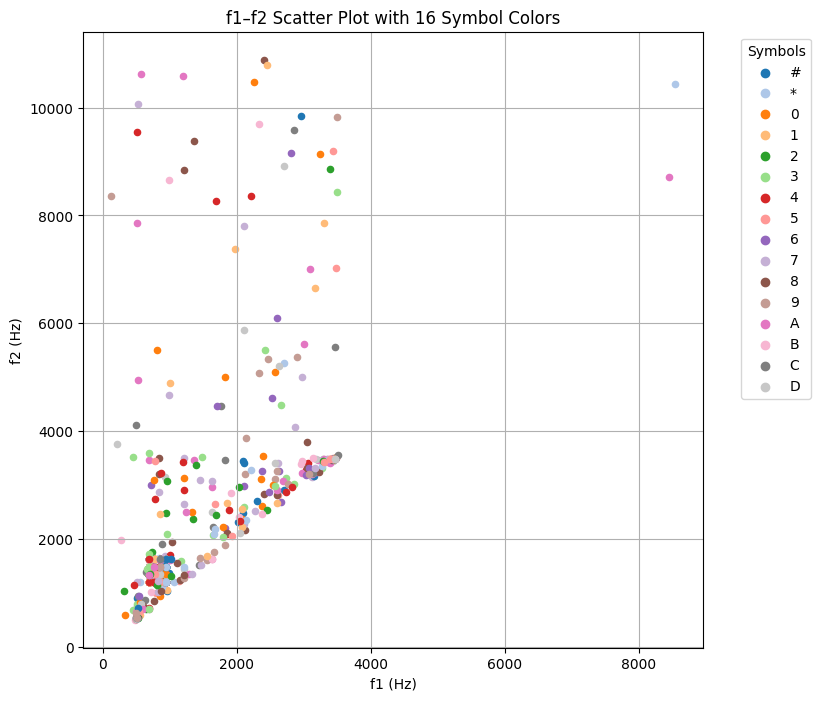

In [349]:
import matplotlib.pyplot as plt
import numpy as np

# F_train: Nx2 array of (f1, f2)
# Y_flat: length-N array/list of labels (strings or ints)

F_train = np.array(F_train)

unique_labels = sorted(list(set(Y_flat)))  # 16 symbols sorted
print("Unique labels:", unique_labels)

# Use a 16-color colormap (tab20 has 20 colors, we take first 16)
cmap = plt.get_cmap('tab20')
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}
plt.figure(figsize=(8, 8))

for (x, y, label) in zip(F_train[:, 0], F_train[:, 1], Y_flat):
    plt.scatter(x, y, color=label_to_color[label], s=20)

plt.xlabel("f1 (Hz)")
plt.ylabel("f2 (Hz)")
plt.title("f1–f2 Scatter Plot with 16 Symbol Colors")
plt.grid(True)

# Legend
for label in unique_labels:
    plt.scatter([], [], color=label_to_color[label], label=str(label))

plt.legend(title="Symbols", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [345]:
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(F_train, Y_flat)

KNeighborsClassifier(n_neighbors=1)

In [347]:
pred_train = clf.predict(F_train)
acc = accuracy_score(Y_flat, pred_train)

print("Training accuracy:", acc)

Training accuracy: 0.7435530085959885


# Question 2

In [5]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

# Question 3

In [ ]:
# Parameters
M = 9
R_values = [1, 3, 5]
epsilon = 0.1 

def gU(lam, a, R):
    """g_U(lambda) function with indicator"""
    lam = np.array(lam)
    result = 0.5 * (1 + np.cos(2 * np.pi * (lam / (a*R) + 0.5)))
    result[(lam < -R*a) | (lam >= 0)] = 0
    return result

def gm(lam, a, R, m):
    """Shifted kernel g^m"""
    return gU(lam - a*m, a, R)

for R in R_values:
    a = 12 / (M + 1 - R)
    
    # Choose lambda range covering all translated kernels
    lam_min = -R*a + a*1 - epsilon
    lam_max = 0 + a*M + epsilon
    lam = np.linspace(lam_min, lam_max, 2000)
    
    plt.figure()
    
    for m in range(1, M+1):
        y = gm(lam, a, R, m)
        plt.plot(lam, y, label=f'm={m}')
    
    plt.title(f'g^m(lambda) for R={R}')
    plt.xlabel('lambda')
    plt.ylabel('g^m(lambda)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'gm_all_m_R{R}.png')
    plt.close()


# Question 4

## Utility functions: 

In [124]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def connected(graph) -> bool:
    #return graph.is_connected()
    return nx.is_connected(graph)

def avg_degree(graph) -> float:
    degrees = [d for n, d in graph.degree()]
    return np.mean(degrees)

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [86]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [87]:
data_df["temp"] = data_df['t']- 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


In [ ]:
temperature_df_clean = temperature_df.dropna(axis=1)
# Original station names
all_stations = temperature_df.columns.tolist()
# Stations remaining after dropna
remaining_stations = temperature_df_clean.columns.tolist()
# Stations with missing values
stations_with_missing = [s for s in all_stations if s not in remaining_stations]

print("Stations with missing temperature values:", stations_with_missing)

Stations with missing temperature values: ['ARZAL', 'BATZ', 'BEG_MEIL', 'BREST-GUIPAVAS', 'BRIGNOGAN', 'CAMARET', 'LANDIVISIAU', 'LANNAERO', 'LANVEOC', 'OUESSANT-STIFF', 'PLOUAY-SA', 'PLOUDALMEZEAU', 'PLOUGONVELIN', 'QUIMPER', 'RIEC SUR BELON', 'SIZUN', 'ST NAZAIRE-MONTOIR', 'VANNES-MEUCON']


In [ ]:
# We keep the valid stations and their coordinates
stations_df['Nom'] = stations_df['Nom'].astype(str).str.strip()
valid_stations = temperature_df_clean.columns.astype(str).str.strip()
stations_df_clean = stations_df[stations_df['Nom'].isin(valid_stations)]
stations_np_clean = stations_df_clean[["Longitude", "Latitude"]].to_numpy()


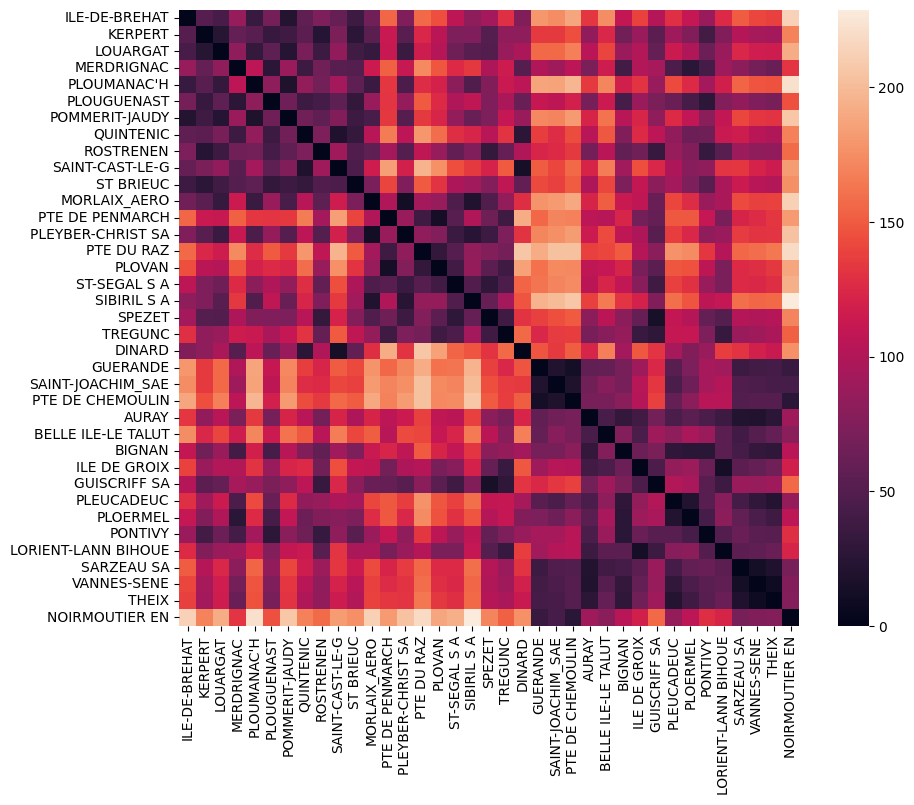

In [117]:
dist_mat_condensed = pdist(stations_np_clean, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax(figsize=(10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df_clean.Nom,
    yticklabels=stations_df_clean.Nom,
    ax=ax,
)

In [ ]:
# We construct the similarity matrix without the threshold and we will add it in the foor loop so we only compute it once.
bandwidth = np.median(dist_mat_condensed)
threshold = 0
similarity_matrix = get_exponential_similarity(dist_mat_condensed, bandwidth, threshold)
similarity_matrix_square = squareform(similarity_matrix)

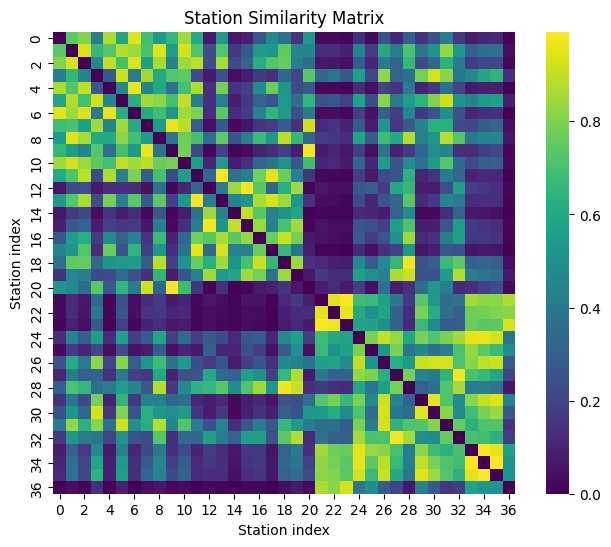

In [127]:
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix_square, cmap='viridis', square=True)
plt.title("Station Similarity Matrix")
plt.xlabel("Station index")
plt.ylabel("Station index")
plt.show()

In [ ]:
# We start with a big threshold and go down until the condition is met.
thresholds = np.linspace(1, 0, 200)
max_threshold = 0
sim_vec = get_exponential_similarity(dist_mat_condensed, bandwidth, threshold=0)
sim_mat = squareform(sim_vec)

for t in thresholds:
    adj = (sim_mat >= t).astype(int)
    np.fill_diagonal(adj, 0)
    G = nx.from_numpy_array(adj)
    
    if connected(G) and avg_degree(G) >= 3:
        max_threshold = t
        break

print("Maximum threshold:", max_threshold)

Maximum threshold: 0.8291457286432161


In [ ]:
# We compute the Laplacian of the graph and make sure the nodes from the temeprature signal and the spatial signal are ordered
D = np.diag(dist_mat_square.sum(axis=1))  # degree matrix
L = D - dist_mat_square  
print(dist_mat_square.shape)
stations_df_clean = stations_df[stations_df['Nom'].isin(temperature_df_clean.columns)].copy()
station_order = stations_df_clean['Nom'].values
temperature_df_ordered = temperature_df_clean[station_order]

(37, 37)


In [ ]:
# We use the formula of smothness and keep the max and minimum values
smoothness_over_time = []

for t, row in temperature_df_ordered.iterrows():
    f_t = row.values 
    S = f_t.T @ L @ f_t
    smoothness_over_time.append(S)

smoothness_series = pd.Series(smoothness_over_time, index=temperature_df_ordered.index)

time_least_smooth = smoothness_series.idxmax()
time_most_smooth = smoothness_series.idxmin()

print("Time of least smooth signal:", pd.to_datetime(time_least_smooth))
print("Time of most smooth signal:", pd.to_datetime(time_most_smooth))


Time of least smooth signal: 2014-01-21 06:00:00
Time of most smooth signal: 2014-01-24 19:00:00


# Question 5

# Question 6

# Question 7